# Corona - German mortality and vaccination timeseries

## Data sources:

1. Mortality statistics for the years 2000 to 2015: [de_statis: Deutschland Sterbefälle 2000-2015](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle-endgueltige-daten.html;jsessionid=7C42BA66C2036FF4141E5AC46AD386D5.live712?nn=209016)
2. Mortality statistics for the years 2016 to 2022 (Aug 21): [de_statis: Deutschland Sterbefälle 2016-2022 ](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.html)
3. Vaccination statistics from 2020 onwards: [impfdashboard.de - Daten zum Downlad](https://impfdashboard.de/daten)


rough outline of the next steps:

1. import the mortality data as a continuous week based time series beginning with the first week of 2010 as index week 1
    - import the data based on maximum granularity regarding sex and age group (done)
    - compose aggregating views (cancelled)


2. import the vaccination data as continuous week based time series
    - get acquainted with the data model (done)
    

3. go and find people already doing analysis on the data, esp. 
    - go and explain this finding: [Starker (negativer) statistischer Zusammenhang zwischen der Covid-19-Impfquote und der Übersterblichkeit](https://idw-online.de/de/news786629)
    - German statistics computes excess mortality as the difference between the median value for the same timeframes of the four previous years: [WHO-Studie zur Corona-Übersterblichkeit nutzt störanfällige Methode](https://www.rwi-essen.de/presse/wissenschaftskommunikation/unstatistik/detail/who-studie-zur-corona-uebersterblichkeit-nutzt-stoeranfaellige-methode)




## Data preparation and first exploration

1. Aligning the data to a common time frame

The mortality data comes week based, the "Impfdashboard" file gives daily numbers. The first steps here are

- aggregation of the vaccination data to a weekly basis
- aligning the week index so that it references the week from the 04th of January 2010, the origin week of the mortality file
- normalize relevant variables to z-scores of themselves to avoid graphical clutter in the plots

2. Join the data and cut the mortality data off at the week of December 28th, 2020 - the beginning of the vaccination campaign

In [224]:
# import requirements

import pandas as pd
import pprint
import statistics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure as fig
#import seaborn as sns
#sns.set_theme(style="darkgrid")

In [225]:
# import mortality data and calculate excess and differential

sterbefaelle = pd.read_csv('../data/deaths/sterbefaelle-2010-2022-je-woche.csv', delimiter=';')

# calculate excess mortality per week following the difference between actual data point 
# and "median of the four prior corresponding data points" methond of  de_statis

i = 0
for x in sterbefaelle.iterrows():    
    sterbefaelle.iloc[3,10]
    if sterbefaelle.loc[i,"week_index"] >= 209:
        sterbefaelle.loc[i,"total_median"] = statistics.median([sterbefaelle["total"][i-208],sterbefaelle["total"][i-156],sterbefaelle["total"][i-104],sterbefaelle["total"][i-52]])
        sterbefaelle.loc[i,"total_excess"] = sterbefaelle["total"][i] - sterbefaelle["total_median"][i]   
    else:
        sterbefaelle["total_median"] = 0
        sterbefaelle["total_excess"] = 0
        
    if sterbefaelle.loc[i,"week_index"] >= 210:  
        sterbefaelle.loc[i,"total_median_diff"]       = 1 - (sterbefaelle["total_median"][i]/sterbefaelle["total_median"][i-1])  
        sterbefaelle.loc[i,"total_excess_diff"]       = 1 - (sterbefaelle["total_excess"][i]/sterbefaelle["total_excess"][i-1])
    else: 
        sterbefaelle.loc[i,"total_median_diff"] = 0
        sterbefaelle.loc[i,"total_excess_diff"] = 0
    
    i = i+1


In [226]:
# import vaccination data 

vaccinations = pd.read_csv('../data/vaccinations/germany_vaccinations_timeseries_v3.tsv', sep='\t')
#vaccinations
vax_columns = [
    'week_index',       # added preemptively for the next step of aggregating data on a weekly basis
    'impfungen',
    'impfungen_biontech',
    'impfungen_biontech_min1',
    'impfungen_biontech_gi',
    'impfungen_biontech_boost1',
    'impfungen_biontech_boost2',
    'impfungen_moderna',
    'impfungen_moderna_min1',
    'impfungen_moderna_gi',
    'impfungen_moderna_boost1',
    'impfungen_moderna_boost2',
    'impfungen_astra',
    'impfungen_astra_min1',
    'impfungen_astra_gi',
    'impfungen_astra_boost1',
    'impfungen_astra_boost2',
    'impfungen_johnson',
    'impfungen_johnson_min1',
    'impfungen_johnson_gi',
    'impfungen_johnson_boost1',
    'impfungen_johnson_boost2',
    'impfungen_novavax',
    'impfungen_novavax_min1',
    'impfungen_novavax_gi',
    'impfungen_novavax_boost1',
    'impfungen_novavax_boost2',
    'personen_min1',
    'impfungen_min1',
    'personen_gi',
    'impfungen_gi',
    'personen_boost1',
    'impfungen_boost1',
    'personen_boost2',
    'impfungen_boost2',
    ]


In [227]:
# extract data from mortality and vaccination sources for the identical timeframe
# the mortality data date range ends with the week from 15th to 21st of August 2022
# this is 86 weeks overlap with the vaccination data.
# For conversion to weekly data the 1st through 602nd rows of the dataframe are grouped


# 1. convert vaccination data to weekly

i = 0
j = 573

for row in vaccinations.iterrows():
    vaccinations.loc[i,"day_index"] = i
    vaccinations.loc[i,"week_index"] = j
    i = i+1
    if i % 7 == 1:
        j = j+1

vax_weekly = vaccinations[vax_columns][1:602].groupby(by="week_index").sum()
vax_weekly.reindex(columns=["week_index","impfungen","impfungen_lag"])



# 2. extract the corresponding part from the mortality data

deaths_list = ["week_index", "monday", "total", "total_excess"]
deaths_weekly = sterbefaelle[deaths_list]
#print(deaths_weekly)


# 3. merge the timeseries to one dataframe. 
# Merge using the default method of inner join.

death_vax_weekly = deaths_weekly.merge(vax_weekly, left_on='week_index', right_on='week_index')#, how='left')
#print(death_vax_weekly)


# 4. create additional variables for combined first and second shots of Pfizer / Biontech
# combined first and second shots of Pfizer / Biontech:
death_vax_weekly["impfungen_biontech_min1_gi"] = (death_vax_weekly["impfungen_biontech_min1"] + death_vax_weekly["impfungen_biontech_gi"])


# 4. calculate the z-scores of the variables "total deaths", "total excess deaths" and "vaccinations (impfungen)"
z_score_list   = ["total","total_excess","impfungen","impfungen_biontech_min1_gi"]
total_mean = death_vax_weekly[z_score_list].mean()
total_std  = death_vax_weekly[z_score_list].std()
death_vax_weekly["total_z"]     = (death_vax_weekly["total"]-total_mean[0])/total_std[0]
death_vax_weekly["total_excess_z"]    = (death_vax_weekly["total_excess"]-total_mean[1])/total_std[1]
death_vax_weekly["impfungen_z"] = (death_vax_weekly["impfungen"]-total_mean[2])/total_std[2]
death_vax_weekly["impfungen_biontech_min1_gi_z"] = (death_vax_weekly["impfungen_biontech_min1_gi"]-total_mean[3])/total_std[3]
#print(death_vax_weekly)

# 5. create a lagged vaccination curve by shifting the data points 23 weeks ahead.
# See https://jdee.substack.com/p/vaccines-and-death-part-1
death_vax_weekly["impfungen_biontech_min1_gi_lag"] = death_vax_weekly["impfungen_biontech_min1_gi"].shift(23)
# and do the same for the z-score
death_vax_weekly["impfungen_biontech_min1_gi_z_lag"] = death_vax_weekly["impfungen_biontech_min1_gi_z"].shift(23)
# shift the total vaccinations and their z-score, too, for good measure
death_vax_weekly["impfungen_lag"] = death_vax_weekly["impfungen"].shift(23)
death_vax_weekly["impfungen_z_lag"] = death_vax_weekly["impfungen_z"].shift(23)
# and for simplicity shift the excess death to -23 weeks
death_vax_weekly["total_excess_lead"] = death_vax_weekly["total_excess"].shift(-23)
#print(death_vax_weekly)


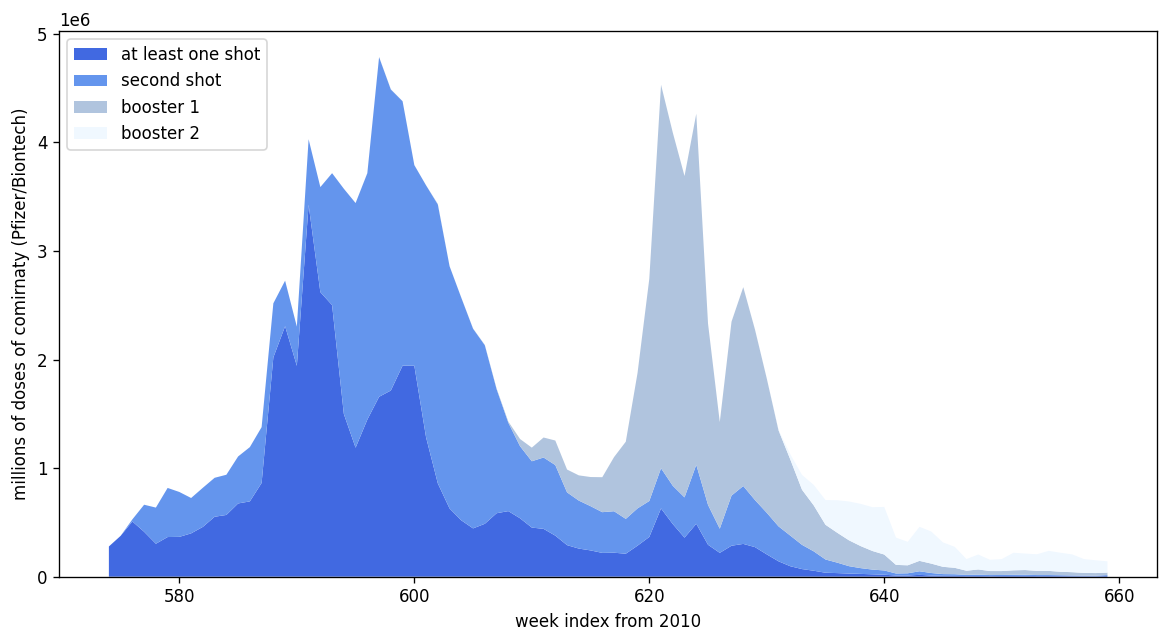

In [228]:
# plot the vaccination campaigns as stacked area chart
fig = plt.figure(figsize=(30*cm, 15*cm))        # an empty figure with no Axes

# define size of plot
cm = 1/2.54  # centimeters in inches
ax1 = plt.subplot()

# Create data
x=death_vax_weekly["week_index"]
y1=death_vax_weekly["impfungen_biontech_min1"]
y2=death_vax_weekly["impfungen_biontech_gi"]
y3=death_vax_weekly["impfungen_biontech_boost1"]
y4=death_vax_weekly["impfungen_biontech_boost2"]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, y3, y4, labels=['at least one shot','second shot','booster 1','booster 2'], colors=['royalblue','cornflowerblue','lightsteelblue','aliceblue'])
ax1.set_xlabel('week index from 2010')
ax1.set_ylabel('millions of doses of comirnaty (Pfizer/Biontech)')
plt.legend(loc='upper left')


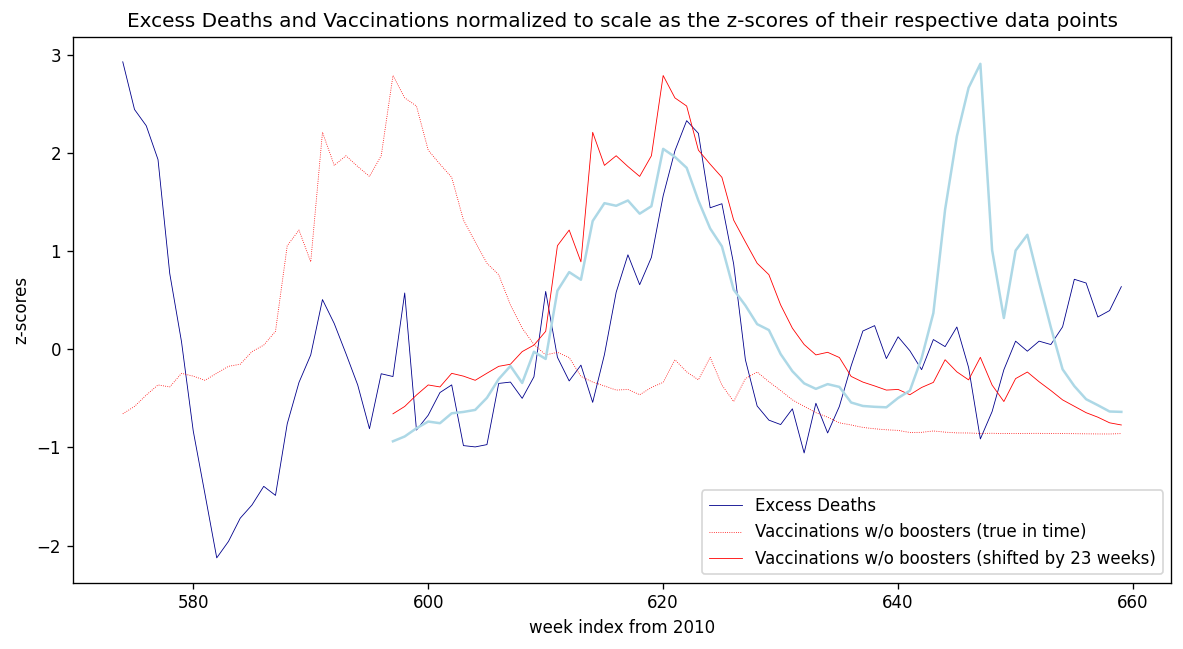

In [229]:
# plot mortality, vaccinations and excess mortality by z-score

# define size of plot
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(30*cm, 15*cm))

# define the plot
plt.title('Excess Deaths and Vaccinations normalized to scale as the z-scores of their respective data points')

ax1 = plt.subplot()
#weeks_since_2010 = death_vax_weekly["week_index"]
total_excess_z = death_vax_weekly["total_excess_z"]
impfungen_z_lag = death_vax_weekly["impfungen_z_lag"]
impfungen_biontech_min1_gi_z = death_vax_weekly["impfungen_biontech_min1_gi_z"]
impfungen_biontech_min1_gi_z_lag = death_vax_weekly["impfungen_biontech_min1_gi_z_lag"]
#total_deaths = death_vax_weekly["total_z"]


l1, = ax1.plot(x, total_excess_z, color = 'darkblue', linewidth = 0.5)
l2, = ax1.plot(x, impfungen_biontech_min1_gi_z, color = 'red', linewidth = 0.5, linestyle = ':')
l3, = ax1.plot(x, impfungen_biontech_min1_gi_z_lag, color = 'red', linewidth = 0.5)
l4, = ax1.plot(x, impfungen_z_lag, color = 'lightblue')

ax1.set_xlabel('week index from 2010')
ax1.set_ylabel('z-scores')

plt.legend([l1, l2, l3], ["Excess Deaths", "Vaccinations w/o boosters (true in time)", "Vaccinations w/o boosters (shifted by 23 weeks)"])

plt.show()

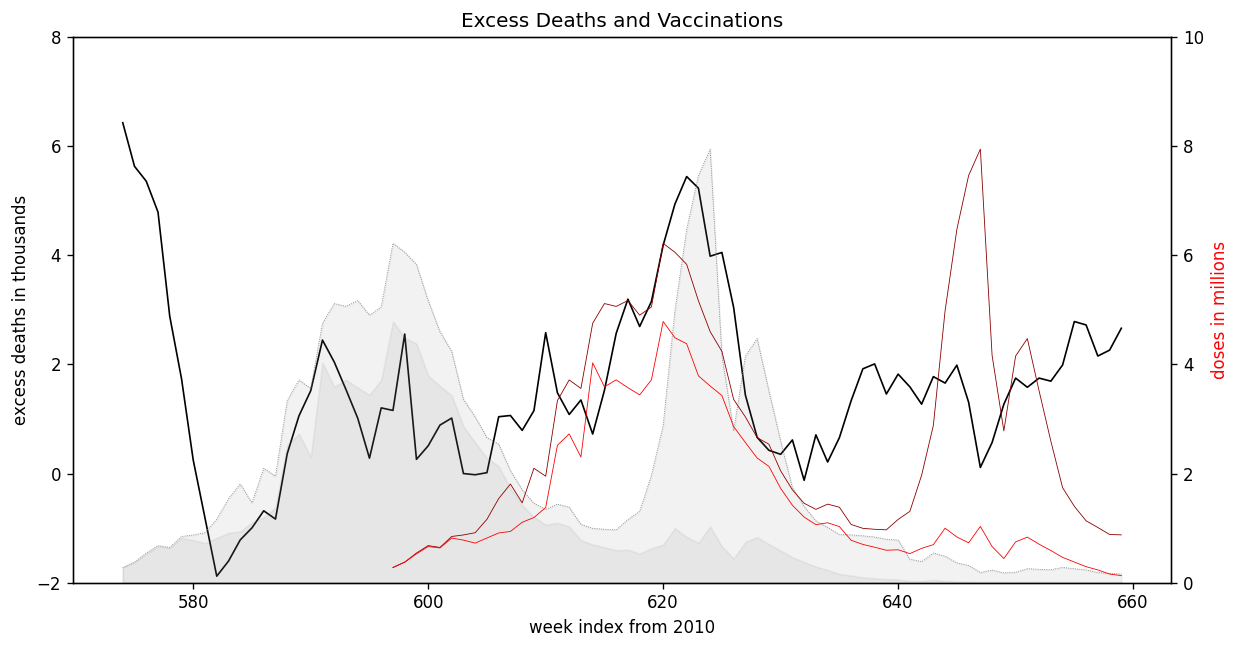

In [230]:
# plot mortality, vaccinations and excess mortality by numeric value

# define size of plot
cm = 1/2.54  # centimeters in inches
fig, ax1 = plt.subplots(figsize=(30*cm, 15*cm))

# define the plot
plt.title('Excess Deaths and Vaccinations')


# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx() 
ax1.set_ylim(-2,8)
ax2.set_ylim(0,10)
ax1.set_xlabel('week index from 2010')
ax1.set_ylabel('excess deaths in thousands')
ax2.set_ylabel('doses in millions', color = 'red')

# define data
week_index = death_vax_weekly["week_index"]
total_excess = death_vax_weekly["total_excess"]/1000
impfungen = death_vax_weekly["impfungen"]/1000000
impfungen_lag = death_vax_weekly["impfungen_lag"]/1000000
impfungen_biontech_min1_gi = death_vax_weekly["impfungen_biontech_min1_gi"]/1000000
impfungen_biontech_min1_gi_lag = death_vax_weekly["impfungen_biontech_min1_gi_lag"]/1000000

plt.fill_between(week_index, impfungen, color="grey", alpha=0.1)
plt.fill_between(week_index, impfungen_biontech_min1_gi, color="grey", alpha=0.1)

ax1.plot(week_index, total_excess, color = 'k', linewidth = 1)
ax2.plot(week_index, impfungen, color = 'grey', linewidth = 0.5, linestyle = ':')
ax2.plot(week_index, impfungen_lag, color = 'darkred', linewidth = 0.5)
ax2.plot(week_index, impfungen_biontech_min1_gi_lag, color = 'red', linewidth = 0.5)




In [256]:
death_vax_weekly

,week_index,monday,total,total_excess,impfungen,impfungen_biontech,impfungen_biontech_min1,impfungen_biontech_gi,impfungen_biontech_boost1,impfungen_biontech_boost2,...,impfungen_biontech_min1_gi,total_z,total_excess_z,impfungen_z,impfungen_biontech_min1_gi_z,impfungen_biontech_min1_gi_lag,impfungen_biontech_min1_gi_z_lag,impfungen_lag,impfungen_z_lag,total_excess_lead
0,574,28.12.20,25541,6428.5,278148,278111,278111,0,0,0,...,278111,2.877914,2.932276,-0.936739,-0.656536,NaN,NaN,NaN,NaN,1156.5
1,575,04.01.21,24919,5630.0,376170,376039,376039,0,0,0,...,376039,2.571843,2.446276,-0.887543,-0.581607,NaN,NaN,NaN,NaN,2556.0
2,576,11.01.21,24532,5357.0,542486,527871,508565,19306,0,0,...,527871,2.381410,2.280117,-0.804072,-0.465432,NaN,NaN,NaN,NaN,260.0
3,577,18.01.21,24129,4791.0,679185,662634,413649,248985,0,0,...,662634,2.183104,1.935626,-0.735465,-0.362318,NaN,NaN,NaN,NaN,508.5
4,578,25.01.21,22674,2881.0,645440,636249,303204,333045,0,0,...,636249,1.467134,0.773122,-0.752401,-0.382507,NaN,NaN,NaN,NaN,888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,655,18.07.22,20762,2785.5,255121,220278,5473,7881,31869,175055,...,13354,0.526286,0.714997,-0.948295,-0.859115,378567.0,-0.579672,1399038.0,-0.374183,NaN
82,656,25.07.22,20045,2723.0,233564,205184,4575,6796,29811,164002,...,11371,0.173468,0.676957,-0.959114,-0.860632,293300.0,-0.644914,1133325.0,-0.507540,NaN
83,657,01.08.22,19399,2153.5,184425,162014,4040,5808,24960,127206,...,9848,-0.144413,0.330336,-0.983776,-0.861797,233131.0,-0.690953,1011047.0,-0.568909,NaN
84,658,08.08.22,19486,2261.0,170429,150823,3696,5635,23799,117693,...,9331,-0.101602,0.395765,-0.990801,-0.862193,158198.0,-0.748288,883284.0,-0.633031,NaN


## Making a pass at an "autoregressive integrated moving average" model for the above data

 primary sources to guide me through python: 
 
 1. [How to Build ARIMA Model in Python for time series forecasting?](https://www.projectpro.io/article/how-to-build-arima-model-in-python/544)
 2. [ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

In [231]:
import statsmodels
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from pmdarima.arima.utils import ndiffs

from numpy import log

In [232]:
# perform the augmented Dickie Fuller test on the data to check for stationarity 

result = adfuller(death_vax_weekly.total_excess.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(death_vax_weekly.total_excess.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


result = adfuller(death_vax_weekly.total_excess.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



ADF Statistic: -3.241940
p-value: 0.017682
ADF Statistic: -7.510723
p-value: 0.000000
ADF Statistic: -7.148791
p-value: 0.000000


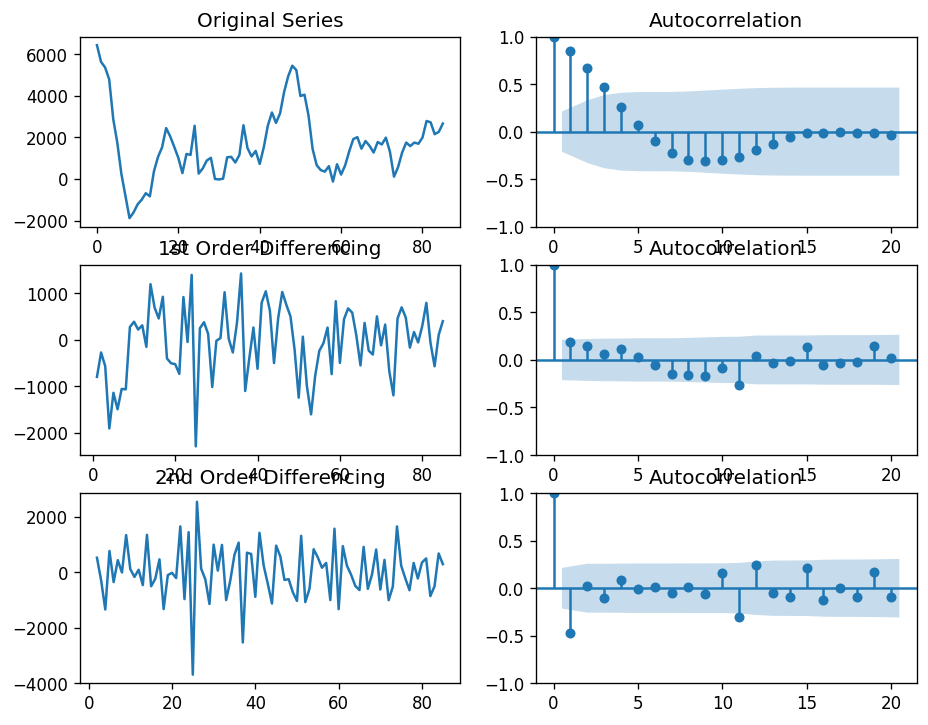

In [233]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(death_vax_weekly.total_excess); axes[0, 0].set_title('Original Series')
plot_acf(death_vax_weekly.total_excess, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(death_vax_weekly.total_excess.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(death_vax_weekly.total_excess.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(death_vax_weekly.total_excess.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(death_vax_weekly.total_excess.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [234]:
# Test for required differencings on the data

y = death_vax_weekly.total_excess
diffs = []

## Adf Test
diffs.append(ndiffs(y, test='adf'))  # 0

# KPSS test
diffs.append(ndiffs(y, test='kpss'))  # 0

# PP test:
diffs.append(ndiffs(y, test='pp'))  # 1

diffs

[0, 0, 1]

In [347]:
# Test for required differencings on the data

y = death_vax_weekly.impfungen_biontech
diffs = []

## Adf Test
diffs.append(ndiffs(y, test='adf'))  # 0

# KPSS test
diffs.append(ndiffs(y, test='kpss'))  # 0

# PP test:
diffs.append(ndiffs(y, test='pp'))  # 1

diffs

[1, 1, 1]

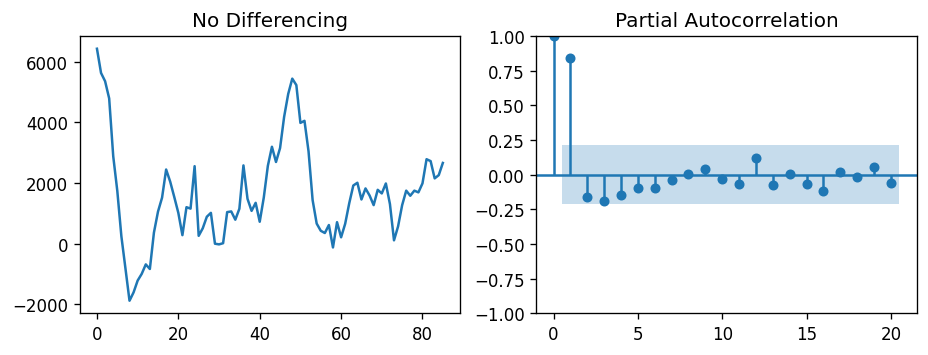

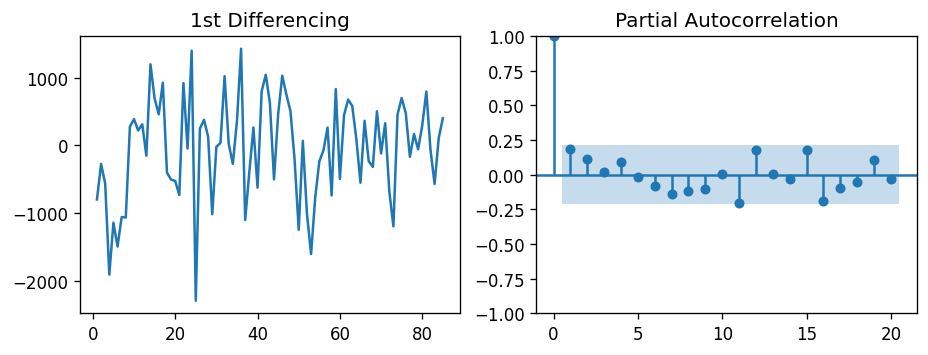

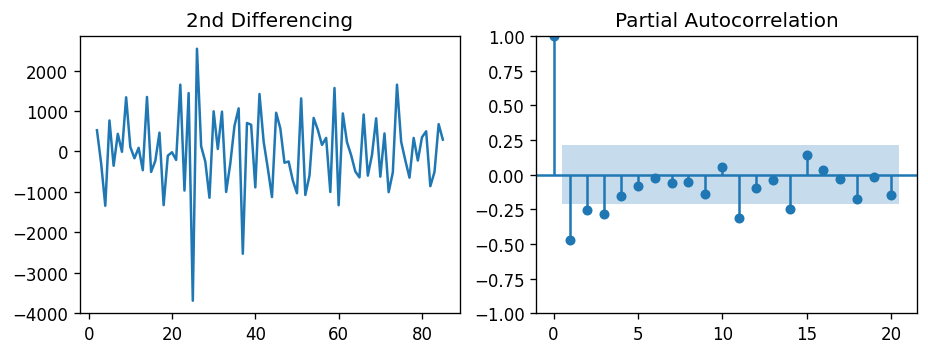

In [236]:
# PACF plot of non differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(death_vax_weekly.total_excess); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(death_vax_weekly.total_excess.dropna(), ax=axes[1], method='ywm')


# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(death_vax_weekly.total_excess.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(death_vax_weekly.total_excess.diff().dropna(), ax=axes[1], method='ywm')

# PACF plot of 2nd differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(death_vax_weekly.total_excess.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(death_vax_weekly.total_excess.diff().diff().dropna(), ax=axes[1], method='ywm')


plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   86
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -682.324
Date:                Thu, 08 Sep 2022   AIC                           1368.648
Time:                        12:52:43   BIC                           1373.533
Sample:                    12-28-2020   HQIC                          1370.613
                         - 08-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1148      0.089      1.298      0.194      -0.059       0.288
sigma2      5.454e+05   7.81e+04      6.979      0.000    3.92e+05    6.99e+05
Ljung-Box (L1) (Q):                   0.34   Jarque-

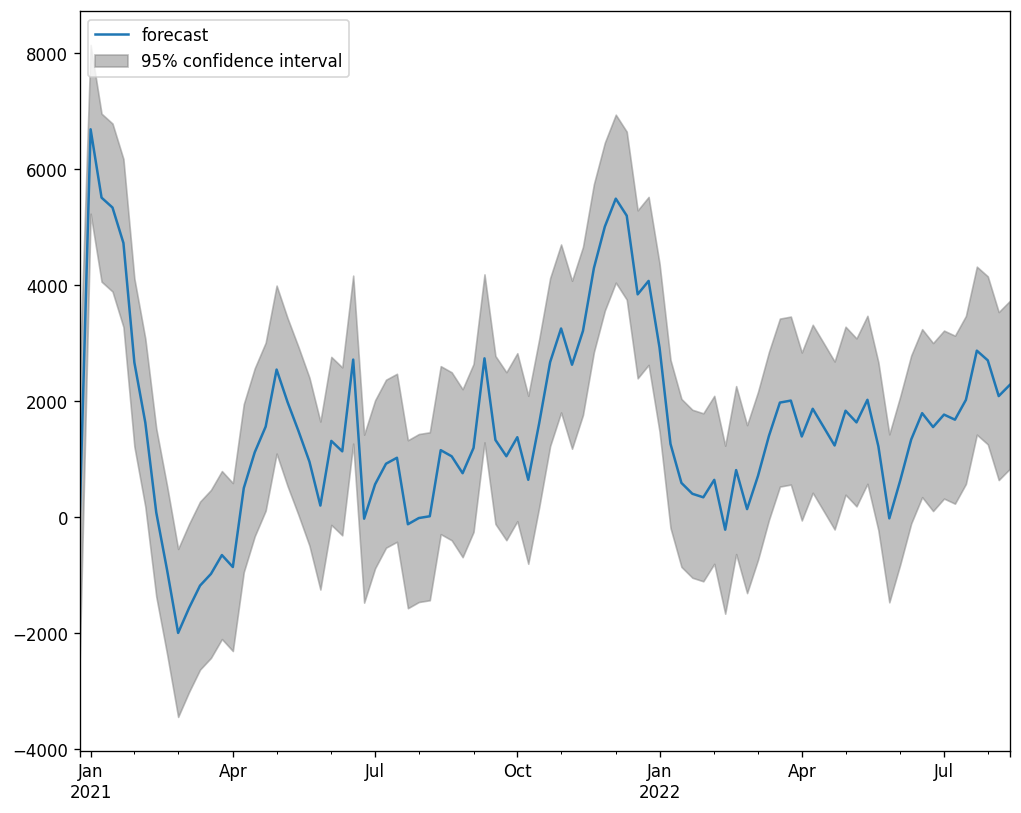

In [352]:
# Actual vs Fitted

nobs = len(death_vax_weekly['total_excess'])
dates = pd.date_range("2020-12-28", freq="W-MON", periods=nobs)
#print(dates)
#print(excess_model.head())
excess_model = death_vax_weekly['total_excess'].tolist()
excess_model_exog = death_vax_weekly['impfungen_biontech'].diff().tolist()
excess_model_exog[0] = 0
excess_model = pd.Series(excess_model, index = dates)
excess_model_input = ARIMA(excess_model, order=(0,1,1), trend="n")
excess_model_result = excess_model_input.fit()

print(excess_model_result.summary())



fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(excess_model_result, start = '2020-12-28', end = '2022-08-15', ax=ax, dynamic = False)
legend = ax.legend(loc="upper left")



# define the plot
plt.title('Actual excess mortality vs fitted model')

ax1 = plt.subplot()

fitted = plot_predict(model_fit, ax=ax)
actual = death_vax_weekly["total_excess"]

l1, = ax1.plot(x, actual, color = 'darkblue', linewidth = 0.5)
l2, = ax1.plot(x, fitted, color = 'red', linewidth = 0.5, linestyle = ':')

ax1.set_xlabel('week index from 2010')
ax1.set_ylabel('excess deaths in thousands')

plt.legend([l1, l2], ["Actual excess deaths", "Fitted predictive model"])

plt.show()




/home/matthiasdaues/Documents/@projects/melita/04_data_management/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/matthiasdaues/Documents/@projects/melita/04_data_management/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


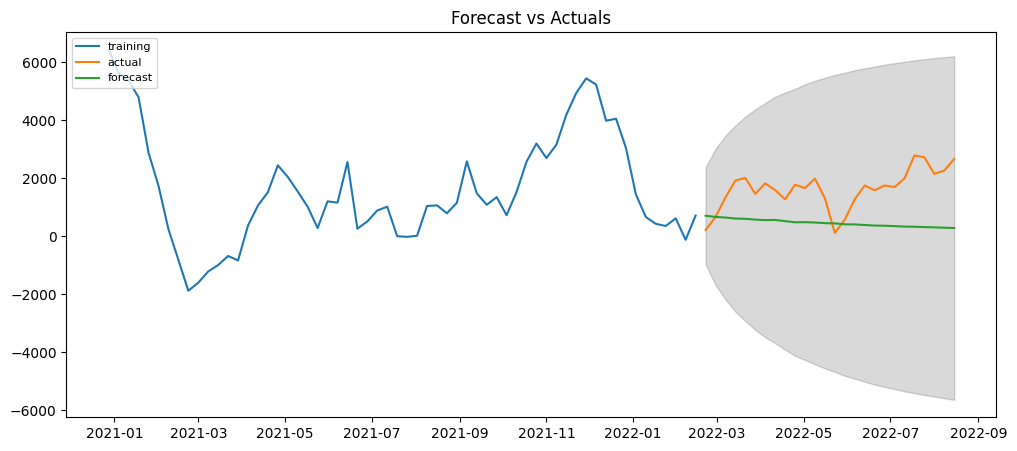

In [357]:
# Build Model

# Create Training and Test
#actual = excess_model
train = excess_model[:60]
test = excess_model[60:]
exog_train = excess_model_exog[:60]
exog_test = excess_model_exog[60:]


# model = ARIMA(train, order=(3,2,1))  
excess_model_input = ARIMA(endog=train, order=(2,0,1), trend="n", exog=exog_train)  
fitted = excess_model_input.fit()  

# Forecast
pred = fitted.get_forecast(26, alpha=0.05, exog=exog_test)  # 95% conf
pred

fc = pred.predicted_mean
lower = pred.conf_int()["lower y"]
upper = pred.conf_int()["upper y"]

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(lower, index=test.index)
upper_series = pd.Series(upper, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
#plt.plot(actual, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [355]:
exogenous

[0,
 97928.0,
 151832.0,
 134763.0,
 -26385.0,
 181071.0,
 -37330.0,
 -55433.0,
 94294.0,
 91855.0,
 28033.0,
 168375.0,
 86214.0,
 183865.0,
 1140697.0,
 208529.0,
 -423610.0,
 1726327.0,
 -440707.0,
 128211.0,
 -143427.0,
 -131799.0,
 276462.0,
 1068974.0,
 -297605.0,
 -109693.0,
 -588283.0,
 -186477.0,
 -171891.0,
 -572801.0,
 -290324.0,
 -283928.0,
 -150853.0,
 -401228.0,
 -305244.0,
 -160640.0,
 -79309.0,
 93243.0,
 -27694.0,
 -267158.0,
 -53704.0,
 -15430.0,
 -1580.0,
 185122.0,
 141872.0,
 632934.0,
 866598.0,
 1788218.0,
 -440328.0,
 -400186.0,
 573799.0,
 -1933186.0,
 -907312.0,
 925190.0,
 318397.0,
 -391171.0,
 -449422.0,
 -474330.0,
 -224270.0,
 -190846.0]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1387.826, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1577.005, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1388.706, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1499.313, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1386.120, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1386.766, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1388.016, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1387.933, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1387.862, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1386.868, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1389.628, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1377.002, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1385.981, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1384.373, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept

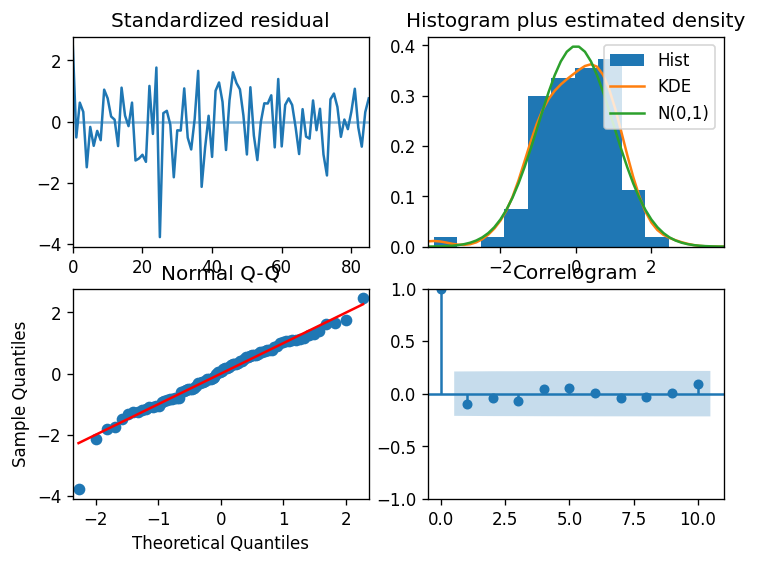

In [161]:
import pmdarima as pm

# SARIMAX Model
model = pm.auto_arima(death_vax_weekly[['total_excess']], #exogenous=df[['impfungen_biontech_min1_gi']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=1,
                           start_P=0, seasonal=False,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

model.summary()
model.plot_diagnostics(figsize=(7,5))
plt.show()